In [94]:
import re 
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from simhash import Simhash

# 核心算法

In [95]:
# MSKTS文本相似度比對算法
url = 'https://gist.githubusercontent.com/skywalker0803r/7c00d680d731b99ab549dd40a96006ce/raw/d9bb060a42285053faa5227df521b43f381f1a0b/MSKTS.py'
exec(requests.get(url).text)

# help function

In [96]:
# 保留英文字母
def keep_alpha(str1): 
  char = "" 
  for x in str(str1):
    if x.isalpha(): 
      char = "".join([char, x])
  return char 

# 基於規則之關鍵字匹配算法
def matching(sentence,database):
  candidate_list = []
  for word in database:
    if word in sentence: 
      candidate_list.append(word)
  return candidate_list

# rule對出來的word若為其他word的子集則剔除
def substringSieve(string_list):
    string_list.sort(key=lambda s: len(s), reverse=True)
    out = []
    for s in string_list:
      if not any([s in o for o in out]):
        out.append(s)
    return out

# 輸入sentence前處理
def preprocess_raw_sentence(x):
  x = str(x).upper() # 轉大寫字串
  x = re.sub('[\u4e00-\u9fa5]', '', x) # 去除中文
  x = re.sub(r'[^\w\s]','',x) # 去除標點符號
  x = x.replace('\n', '').replace('\r', '').replace('\t', '') # 去除換行符號
  str.strip(x) # 移除左右空白
  x = x.replace('   ', ' ')# 去除三重空白
  x = x.replace('  ', ' ')# 去除雙重空白
  x = ' ' + x + ' '# 出現在頭的 就不可能對到前後加空格的 這種情形要想想怎麼對照(加上左右空白)
  return x

# 產品後處理
def product_name_postprocess(x):
  x = str(x).upper() # 轉大寫字串
  x = x.replace('-','')# 去除標點符號
  x = x.replace('.','')# 去除標點符號
  x = x.replace(',','')# 去除標點符號
  x = x.strip() # 去除空白
  return x

# 基於關鍵字比對方法的預測函數
def predict_keyword(title,test_df,Unrecognized,input_col,database,output_col):
  result = []
  for i in tqdm(test_df.index):
    candidate_list = matching(
        sentence = test_df.loc[i,input_col],
        database = set(database) - set(Unrecognized)
        )
    result.append(substringSieve(candidate_list))
  test_df[output_col] = result
  return test_df

# 載入數據


In [97]:
# 資料庫
database = pd.read_excel('../data/combined_excel.xlsx')
# 測試數據
test_data = pd.read_csv('../data/測試數據/0927到2022.csv')

# 讀取產品名資料庫
品名寶典 = pd.read_excel('../data/寶典/寶典人工處理後/寶典.v8.202111202.xlsx',engine='openpyxl')[['CODIV','DIVNM','ITEMNM']]
品名寶典 = 品名寶典.rename(columns={'ITEMNM':'品名','DIVNM':'公司事業部門','CODIV':'公司代號'})
品名寶典['品名'] = 品名寶典['品名'].apply(lambda x:product_name_postprocess(x))

# 讀取開狀人資料庫
開狀人寶典 = pd.read_csv('../data/寶典/開狀人寶典.csv')

# 讀取公司寶典
公司寶典 = pd.read_csv('../data/寶典/公司寶典加尾綴.csv')

# 按照時間排序資料

In [98]:
def sort_by_form(df):
    df = df.sort_values(by='from')
    df = df.reset_index(drop=True)
    return df
database = sort_by_form(database)
test_data = sort_by_form(test_data)

# 預處理函數

In [99]:
產品名輸入 = '45A' #產品名
開狀人輸入 = '50' #開狀人
受益人輸入 = '59' #受益人
開狀銀行輸入 = 'LTADDRESS.1' #銀行輸入
輸出欄位 = ['產品名','開狀人','受益人','開狀銀行']
輸入欄位 = ['45A','50','59','LTADDRESS.1']
# 針對模型輸入做預處理
def 預處理(df):
  產品名輸入 = '45A' #產品名
  開狀人輸入 = '50' #開狀人
  受益人輸入 = '59' #受益人
  開狀銀行輸入 = 'LTADDRESS.1' #銀行輸入
  for i in [產品名輸入,開狀人輸入,受益人輸入]:
    df[i] = df[i].apply(lambda x:preprocess_raw_sentence(x))
  return df

# 抽特徵函數

In [100]:
def 抽特徵(df):
  # 1.預測產品
  df = predict_keyword(
      title = '正在預測產品',
      test_df = df,
      Unrecognized = ['PE','MA','EA','GRADE','INA','PACK','PP','PA','',' '],
      input_col = 產品名輸入,
      database = 品名寶典['品名'].values.tolist(),
      output_col = '產品名',
      )

  # 2.預測開狀人
  df = predict_keyword(
      title = '正在預測開狀人',
      test_df = df,
      Unrecognized = ['',' '],
      input_col = 開狀人輸入,
      database = 開狀人寶典['開狀人'].values.tolist(),
      output_col = '開狀人',
      )

  # 3.預測公司
  df = predict_keyword(
      title = '正在預測受益人',
      test_df = df,
      Unrecognized = ['',' '],
      input_col = 受益人輸入,
      database = 公司寶典['公司英文名稱'].values.tolist(),
      output_col = '受益人',
      )

  # 4.預測銀行
  df['開狀銀行'] = df[開狀銀行輸入].apply(lambda x:str(x)[:8])
  return df

In [101]:
# 準備訓練資料
train_data = database
train_data = 抽特徵(預處理(train_data))
train_data[輸出欄位].head()

C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20737 [00:00<?, ?it/s]

  0%|          | 0/20737 [00:00<?, ?it/s]

  0%|          | 0/20737 [00:00<?, ?it/s]

,產品名,開狀人,受益人,開狀銀行
0,[NAN],[],[],BKTWTWT0
1,[NAN],[],[],BKTWTWT0
2,[NAN],[],[],BKTWTWT0
3,[NAN],[],[],BKTWTWT0
4,[NAN],[],[],BKTWTWT0


In [102]:
# 準備測試資料
test_data = 抽特徵(預處理(test_data))

test_data[輸出欄位].head()

C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2427 [00:00<?, ?it/s]

  0%|          | 0/2427 [00:00<?, ?it/s]

  0%|          | 0/2427 [00:00<?, ?it/s]

,產品名,開狀人,受益人,開狀銀行
0,[PVC SUSPENSION RESIN],[DEEP JYOTI WAX TRADERS],[FORMOSA PLASTICS],ICICINBB
1,[MONO ETHYLENE GLYCOL MEG],[CHEMNEWS CORP],[NAN YA PLASTICS],CZNBKRSE
2,[MONO ETHYLENE GLYCOL MEG],[CHEMNEWS CORP],[NAN YA PLASTICS],CZNBKRSE
3,[PVC SUSPENSION RESIN],[GOVERDHAN ENERGY],[FORMOSA PLASTICS],INDBINBB
4,[PVC TRANSPARENT SHEET],[SOJITZ CORPORATION],[NAN YA PLASTICS],BOTKJPJT


# 模型測試

In [103]:
def 根據特定欄位和索引給出候選答案清單(col,idx,k,database_size=100,database=None,test_data=None):
  # 預處理
  database['處理過的資料'] = (database[col]).apply(keep_alpha)
  test_data['處理過的資料'] = (test_data[col]).apply(keep_alpha)
  # 建立模型
  model = MSKTS()
  model.fit(database['處理過的資料'].sample(database_size).values.tolist())
  # 產生預測答案清單
  output = model.predict(test_data['處理過的資料'][idx],k=k)
  output = [i[0] for i in output]
  預測答案清單 = database.loc[database['處理過的資料'].isin(output),'EXPNO'].dropna().apply(lambda x:str(x)[:2]).values.tolist()
  return 預測答案清單

# 正確率

In [104]:
correct = []
for idx in tqdm(range(10)):
  o1 = 根據特定欄位和索引給出候選答案清單(
    col='產品名',idx=idx,k=3,database_size=len(database),database=database,test_data=test_data)
  o2 = 根據特定欄位和索引給出候選答案清單(
    col='開狀人',idx=idx,k=3,database_size=len(database),database=database,test_data=test_data)
  o3 = 根據特定欄位和索引給出候選答案清單(
    col='受益人',idx=idx,k=3,database_size=len(database),database=database,test_data=test_data)
  o4 = 根據特定欄位和索引給出候選答案清單(
    col='開狀銀行',idx=idx,k=3,database_size=len(database),database=database,test_data=test_data)
  o = o1#+o2+o3#+o4
  ensemble_output = max(o,key=o.count)
  if ensemble_output == test_data['推薦公司事業部'][idx]:
    correct.append(True)
  else:
    correct.append(False)
print('正確率:',np.mean(correct))

C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/10 [00:00<?, ?it/s]

正確率: 0.7


# 觀察不同資料筆數 對正確率的影響

In [105]:
def 目標函數(database_size):
  correct = []
  for idx in tqdm(range(10)):
    o1 = 根據特定欄位和索引給出候選答案清單(
      col='產品名',idx=idx,k=3,database_size=database_size,database=database,test_data=test_data)
    o2 = 根據特定欄位和索引給出候選答案清單(
      col='開狀人',idx=idx,k=3,database_size=database_size,database=database,test_data=test_data)
    o3 = 根據特定欄位和索引給出候選答案清單(
      col='受益人',idx=idx,k=3,database_size=database_size,database=database,test_data=test_data)
    o4 = 根據特定欄位和索引給出候選答案清單(
      col='開狀銀行',idx=idx,k=3,database_size=database_size,database=database,test_data=test_data)
    o = o1#+o2+o3+o4
    try:
      ensemble_output = max(o,key=o.count)
    except:
      ensemble_output = 'not find'
    if ensemble_output == test_data['推薦公司事業部'][idx]:
      correct.append(True)
    else:
      correct.append(False)
  return np.mean(correct)

In [106]:
x = [
    10,
    100,
    1000,
    10000,
    len(database)
    ]
y = [目標函數(i) for i in x]


C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[10, 100, 1000, 10000, 20737] [0.2, 0.6, 0.6, 0.7, 0.7]


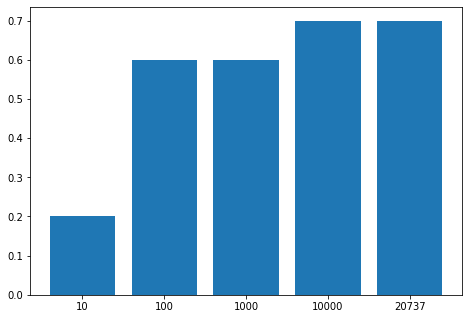

In [107]:
import matplotlib.pyplot as plt
print(x,y)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar([str(i) for i in x],y)
plt.show()

# 滾動式預測

In [108]:
def 目標函數(database_size):
  correct = []
  for idx in tqdm(range(len(test_data)-10,len(test_data),1)):
    can_add_data = test_data[test_data['from'] < test_data.loc[idx,'from']] #此時間以前
    can_add_data = can_add_data.rename(columns={'推薦公司事業部':'EXPNO'}) #統一命名
    can_add_data = can_add_data[輸入欄位+輸出欄位+['EXPNO']] #保留必要欄位
    
    o1 = 根據特定欄位和索引給出候選答案清單(
      col='產品名',idx=idx,k=3,
      database_size=database_size,
      database=database.append(can_add_data),
      test_data=test_data)
    
    o2 = 根據特定欄位和索引給出候選答案清單(
      col='開狀人',idx=idx,k=3,
      database_size=database_size,
      database=database.append(can_add_data),
      test_data=test_data)
    
    o3 = 根據特定欄位和索引給出候選答案清單(
      col='受益人',idx=idx,k=3,
      database_size=database_size,
      database=database.append(can_add_data),
      test_data=test_data)
    
    o4 = 根據特定欄位和索引給出候選答案清單(
      col='開狀銀行',idx=idx,k=3,
      database_size=database_size,
      database=database.append(can_add_data),
      test_data=test_data)
    
    o = o1#+o2+o3+o4
    
    try:
      ensemble_output = max(o,key=o.count)
    except:
      ensemble_output = 'not find'
    
    if ensemble_output == test_data['推薦公司事業部'][idx]:
      correct.append(True)
    else:
      correct.append(False)
  
  return np.mean(correct)

In [109]:
x = [
    10,
    100,
    1000,
    10000,
    len(database)
    ]
y = [目標函數(i) for i in x]


C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[10, 100, 1000, 10000, 20737] [0.2, 0.3, 0.5, 0.6, 0.6]


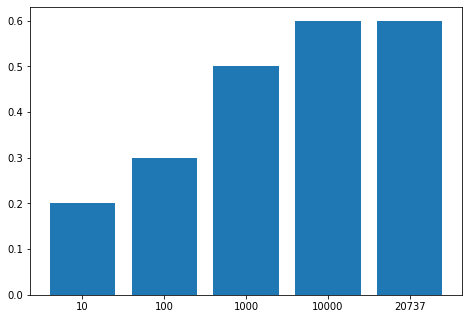

In [113]:
import matplotlib.pyplot as plt
print(x,y)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar([str(i) for i in x],y)
plt.show()